In [1]:
import cv2
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
def get_image_paths(folder_path):
    """
    Get paths of image files from a folder.

    :param folder_path: String representing the path to the folder.
    :return: List of strings representing paths to image files.
    :raise ValueError: If folder_path is not a directory.
    """
    if not os.path.isdir(folder_path):
        raise ValueError(f"Error: {folder_path} is not a directory.")

    files = os.listdir(folder_path)
    image_files = [file for file in files if file.lower().endswith(".jpg")]
    return image_files

In [3]:
def rename_images(folder_path):
    """
    Rename image files in a folder.

    :param folder_path: String representing the path to the folder.
    """
    image_files = get_image_paths(folder_path)

    for i, image_file in enumerate(tqdm(image_files, desc="Renaming images")):
        old_path = os.path.join(folder_path, image_file)
        new_name = f"image_{i}.jpg"
        new_path = os.path.join(folder_path, new_name)
        os.rename(old_path, new_path)

In [4]:
def convert_to_grayscale(source_folder, destination_folder):
     """
    Convert color images to grayscale.

    :param source_folder: String representing the path to the source folder containing color images.
    :param destination_folder: String representing the path to the destination folder for grayscale images.
    """
    image_files = get_image_paths(source_folder)

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for image_file in tqdm(image_files, desc="Converting to grayscale"):
        source_path = os.path.join(source_folder, image_file)
        destination_path = os.path.join(destination_folder, image_file)
        image = Image.open(source_path)
        grayscale_image = image.convert("L")
        grayscale_image.save(destination_path)

In [5]:
def generate_phases(source_folder, destination_folder):
    """
    Generate phase images from grayscale images.

    :param source_folder: String representing the path to the source folder containing grayscale images.
    :param destination_folder: String representing the path to the destination folder for phase images.
    """
    image_files = get_image_paths(source_folder)

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    for image_file in tqdm(image_files, desc="Generating phase images"):
        source_path = os.path.join(source_folder, image_file)
        destination_path = os.path.join(destination_folder, image_file)
        image = cv2.imread(source_path, cv2.IMREAD_GRAYSCALE)
        dft = np.fft.fft2(image)
        dft_shift = np.fft.fftshift(dft)
        phase_spectrum = np.angle(dft_shift)
        phase_image = Image.fromarray(phase_spectrum, "L")
        phase_image.save(destination_path)

In [6]:
if __name__ == "__main__":
    color_path = "data/color"
    grayscale_path = "data/grayscale"
    phases_path = "data/phases"

    try:
        rename_images(color_path)
        convert_to_grayscale(color_path, grayscale_path)
        generate_phases(grayscale_path, phases_path)
    except ValueError as e:
        print(e)

Generating phase images: 100%|██████████| 5000/5000 [01:11<00:00, 70.21it/s]


In [2]:
def unet(input_shape):
     """
    Create U-Net model architecture.

    :param input_shape: Tuple representing the input shape of the model.
    :return: U-Net model.
    """
    inputs = Input(input_shape)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [18]:
input_shape = (128, 128, 1)
learning_rate = 0.00001
num_epochs = 15
batch_size = 32

In [19]:
model = unet(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error')

In [11]:
grayscale_images_folder = "data/grayscale"
phases_images_folder = "data/phases"

grayscale_images = []
phases_images = []

for filename in os.listdir(grayscale_images_folder):
    grayscale_image_path = os.path.join(grayscale_images_folder, filename)
    phases_image_path = os.path.join(phases_images_folder, filename)
    grayscale_image = np.array(Image.open(grayscale_image_path))
    phases_image = np.array(Image.open(phases_image_path))
    grayscale_images.append(grayscale_image)
    phases_images.append(phases_image)

grayscale_images = np.array(grayscale_images)
phases_images = np.array(phases_images)
grayscale_images = grayscale_images / 255.0
phases_images = phases_images / 255.0

In [12]:
class PrintProgress(tf.keras.callbacks.Callback):
    """
    Callback class to print training progress after each epoch.

    Prints the epoch number along with training and validation loss.

    :param num_epochs: Integer representing the total number of epochs.
    """
    def on_epoch_end(self, epoch, logs=None):
        """
        Method called at the end of each epoch.

        :param epoch: Integer representing the current epoch number.
        :param logs: Dictionary containing the training and validation loss.
        """
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {logs["loss"]}, Validation Loss: {logs["val_loss"]}')
progress_callback = PrintProgress()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(phases_images, grayscale_images, test_size=0.2, random_state=42)

In [20]:
model.fit(X_train, y_train,
          epochs=num_epochs,
          batch_size=batch_size,
          validation_split=0.2,
          callbacks=[progress_callback])

mse_values = []
for i in range(len(X_test)):
    y_pred = model.predict(X_test[i:i+1])  
    mse = np.mean(np.square(y_pred - y_test[i:i+1]))  
    mse_values.append(mse)

average_mse = np.mean(mse_values)
print(f'Average MSE on the test set: {average_mse}')

print('Finished Training')

model.save('unet_model10.h5')

Epoch 1/15
100/100 [==============================] - 968s 10s/step - loss: 0.1128 - val_loss: 0.0758
Epoch 2/15
100/100 [==============================] - 964s 10s/step - loss: 0.0917 - val_loss: 0.0792
Epoch 3/15
100/100 [==============================] - 963s 10s/step - loss: 0.0729 - val_loss: 0.0757
Epoch 4/15
100/100 [==============================] - 964s 10s/step - loss: 0.0672 - val_loss: 0.0733
Epoch 5/15
100/100 [==============================] - 963s 10s/step - loss: 0.0654 - val_loss: 0.0715
Epoch 6/15
100/100 [==============================] - 964s 10s/step - loss: 0.0644 - val_loss: 0.0692
Epoch 7/15
100/100 [==============================] - 965s 10s/step - loss: 0.0636 - val_loss: 0.0696
Epoch 8/15
100/100 [==============================] - 964s 10s/step - loss: 0.0629 - val_loss: 0.0669
Epoch 9/15
100/100 [==============================] - 964s 10s/step - loss: 0.0620 - val_loss: 0.0717
Epoch 10/15
100/100 [==============================] - 964s 10s/step - loss: 0.060

C:\Users\sandr\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 440ms/step


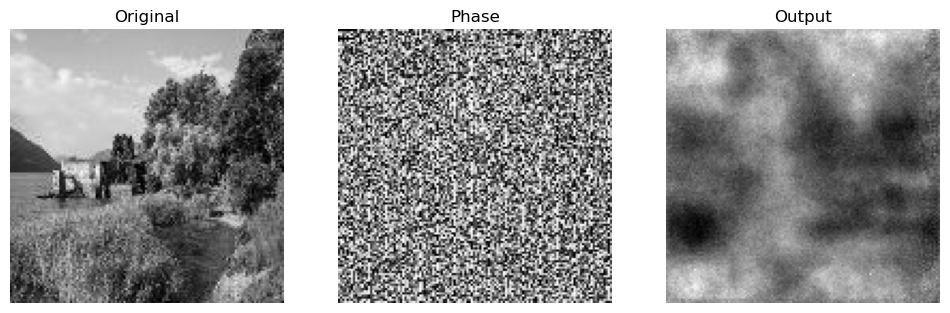

In [21]:
def print_example(index):
    """
    Print an example of original, phase, and output images.

    :param index: Integer representing the index of the example in the test set.
    """
    original_image = y_test[index]
    phase_image = X_test[index]
    original_image = np.expand_dims(original_image, axis=-1)
    phase_image = np.expand_dims(phase_image, axis=-1)
    output_image = model.predict(phase_image[np.newaxis, ...])

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(original_image.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Phase')
    plt.imshow(phase_image.squeeze(), cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Output')
    plt.imshow(output_image.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

print_example(0)